# Implementation of the Newmark-β time-stepping

In this notebook, we present an  implementation of the Newmark-β time-stepping technique, see also [Jérémy Bleyer's code](https://comet-fenics.readthedocs.io/en/latest/demo/elastodynamics/demo_elastodynamics.py.html). We adopt here an approach that is more “matrix-oriented”: `FEniCS` is used to assemble the matrices of the problem, discretized in space. Once these matrices are assembled, we write the various linear algebra operations explicitly.

We will explore various versions of the Newmark method, including the so-called “explicit” version.

We consider a cantilever beam of size `Lx × Ly` (2D, plane stress), fixed at its `x = 0` end, and subjected to a a transversal load at `x = Lx`. 


Introduction and elastodynamics equation
----------------------------------------

The elastodynamics equation combine the balance of linear momentum:

$$\nabla \cdot \sigma + \rho b = \rho \ddot{u}$$

where $u$ is the displacement vector field,
$\ddot{u}=\partial^2 u/\partial t^2$ is the acceleration, $\rho$ the
material density, $b$ a given body force and $\sigma$ the stress tensor
which is related to the displacement through a constitutive equation. In
the case of isotropic linearized elasticity, one has:

$$\sigma =\lambda \text{tr}(\varepsilon)\mathbb{1} + 2\mu\varepsilon$$

where $\varepsilon = (\nabla u + (\nabla u)^T)/2$ is the linearized
strain tensor, $\mathbb{1}$ is the identity of second-rank tensors and
$\lambda=\dfrac{E\nu}{(1+\nu)(1-2\nu)},\mu=\dfrac{E}{2(1+\nu)}$ are the
Lame coefficients given as functions of the Young modulus $E$ and the
Poisson ratio $\nu$.

The weak form is readily obtained by integrating by part the balance
equation using a test function $v\in V$ with $V$ being a suitable
function space that satisfies the displacement boundary conditions:

$$\int_{\Omega} \rho \ddot{u}\cdot v \, {\rm d} x + \int_{\Omega} \sigma(u):\varepsilon(v) \, {\rm d} x =
\int_{\Omega} \rho b \cdot v  \, {\rm d} x 
+ \int_{\partial\Omega} (\sigma\cdot n) \cdot v \, {\rm d} s \quad \text{for all } v \in V
$$

The previous equation can be written as follows:

$$
\text{Find }u\in V\text{ such that } m(\ddot{u},v) + k(u,v) = L(v) \quad \text{for all } v\in V
$$

where $m$ is the symmetric bilinear form associated with the mass matrix
and $k$ the one associated with the stiffness matrix.

After introducing the finite element space interpolation, one obtains
the corresponding discretized evolution equation:

$$\text{Find }\{u\}\in\mathbb{R}^n\text{ such that } \{v\}^T[M]\{\ddot{u}\} + \{v\}^T[K]\{u\} = \{v\}^T\{F\} \quad \text{for all } \{v\}\in\mathbb{R}^n$$

which is a generalized $n$-dof harmonic oscillator equation.

Quite often in structural dynamics, structures do not oscillate
perfectly but lose energy through various dissipative mechanisms
(friction with air or supports, internal dissipation through plasticity,
damage, etc.). Dissipative terms can be introduced at the level of the
constitutive equation if these mechanisms are well known but quite often
it is not the case. Dissipation can then be modeled by adding an *ad
hoc* damping term depending on the structure velocity $\dot{u}$ to the
previous evolution equation:

$$\text{Find }u\in V\text{ such that } m(\ddot{u},v) + c(\dot{u},v) + k(u,v) = L(v) \quad \text{for all } v\in V$$

The damping form will be considered here as bilinear and symmetric,
being therefore associated with a damping matrix $[C]$.

### Rayleigh damping

When little is known about the origin of damping in the structure, a
popular choice for the damping matrix, known as *Rayleigh damping*,
consists in using a linear combination of the mass and stiffness matrix
$[C] = \eta_M[M]+\eta_K[K]$ with two positive parameters $\eta_M,\eta_K$
which can be fitted against experimental measures for instance (usually
by measuring the damping ratio of two natural modes of vibration).

In [1]:
import dolfin
import numpy as np
import matplotlib.pyplot as plt
import time
dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["optimize"] = True

In [2]:
def local_project(v, V, u=None):
    """Element-wise projection using LocalSolver"""
    dv = dolfin.TrialFunction(V)
    v_ = dolfin.TestFunction(V)
    a_proj = dolfin.inner(dv, v_)*dx
    b_proj = dolfin.inner(v, v_)*dx
    solver = dolfin.LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = dolfin.Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

### Geometry

In [3]:
Lx = 1.0
Ly = 0.1
Ny = 10 # Number of elements in the y-direction

### Material parameters

In [4]:
E  = 1000.
nu = 0.3
rho = dolfin.Constant(1.)
eta_m = dolfin.Constant(0.)
eta_k = dolfin.Constant(0.)

### Loading parameters

A time-dependent traction is applied at the $x = L_x$ face as follows
\begin{equation}
\vec T = \begin{cases}
\displaystyle\frac{t}{t_{\mathrm{c}}}\vec T_{\mathrm{max}} & t \leq t_{\mathrm{c}}\\[.2em]
\vec 0 & t > t_{\mathrm{c}}
\end{cases}
\end{equation}
where $t_{\mathrm{c}}$ is a “cut-off” time. Note that depending on the direction of the applied traction, we will need to select different values for `t_c` and `T_max`.

In [5]:
t_c = 0.1
T_max = 1

### Time-discretization parameters

In [6]:
t_end = 4. # End of simulation
num_steps  = 100 # Total number of steps
dt = t_end/num_steps

Parameters of the Newmark-β method.
A popular choiche of parameters which ensures unconditional stability, optimal dissipation and second-order accuracy is:
$$\gamma=\frac{1}{2},\quad \beta=\frac{1}{4}$$

In [7]:
gamma = 1./2.
beta = 1./4.

## Mesh generation

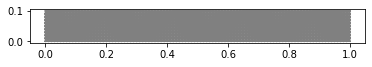

In [8]:
p1 = dolfin.Point(0., 0.)
p2 = dolfin.Point(Lx, Ly)

Nx = int(Ny*Lx/Ly)
mesh = dolfin.RectangleMesh(p1, p2, Nx, Ny)
dolfin.plot(mesh)

In [9]:
left = dolfin.CompiledSubDomain("on_boundary && near(x[0],0)")
right = dolfin.CompiledSubDomain("on_boundary && near(x[0], L)", L=p2.x())
top = dolfin.CompiledSubDomain("on_boundary && near(x[1], H)", H=p2.y())
bottom = dolfin.CompiledSubDomain("on_boundary && near(x[1], 0)")

boundary_indices = {"left": 0, "right": 1, "top": 2, "bottom": 3}
boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
left.mark(boundary_markers, boundary_indices["left"])
right.mark(boundary_markers, boundary_indices["right"])
top.mark(boundary_markers, boundary_indices["top"])
bottom.mark(boundary_markers, boundary_indices["bottom"])

ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

### Estimation of the critical time step for stability of explicit methods (see pag.41 of the slides)

In [10]:
c_e = np.sqrt(E/float(rho)) # Rayleigh wave speed
l_e = mesh.rmin() # mesh size
dt_crit = l_e/c_e 
print(f"Time step: {dt:.3e} - Critical time step {dt_crit:.3e}")

Time step: 4.000e-02 - Critical time step 9.262e-05


## Space discretization

In [11]:
V = dolfin.VectorFunctionSpace(mesh, "CG", 1)
Vsig = dolfin.TensorFunctionSpace(mesh, "DG", 0)

In [12]:
zero = dolfin.Constant((0.,0.))
bcs = [dolfin.DirichletBC(V, zero, left)]

In [13]:
mu = dolfin.Constant(E/(2.*(1.+nu)))
lambda_ = dolfin.Constant(E*nu/((1.+nu)*(1.-2.*nu)))
# Plane-stress condition
lambda_ = 2*lambda_*mu/(lambda_+2*mu)

In [14]:
traction = dolfin.Expression((0,"t <= t_c ? T_max*t/t_c : 0"), t=0, t_c=t_c, T_max=T_max, degree=0)

### Time discretization using the Newmark-$\beta$ method

We now introduce a time discretization of the interval study $[0;T]$ in
$N+1$ time increments $t_0=0,t_1,\ldots,t_N,t_{N+1}=T$ with
$\Delta t=T/N$ denoting the time step (supposed constant). The
resolution will make use of the generalized-$\alpha$ method which can be
seen as an extension of the widely used Newmark-$\beta$ method in
structural dynamics. As an implicit method, it is unconditionally stable
for a proper choice of coefficients so that quite large time steps can
be used. It also allows for high frequency dissipation and offers a
second-order accuracy, i.e. in $O(\Delta t^2)$.

The method consists in solving the dynamic evolution equation at
intermediate time between $t_n$ and $t_{n+1}$ as follows:

$$[M]\{\ddot{u}_{n+1}\} + [C]\{\dot{u}_{n+1}\}+[K]\{u_{n+1}\} = \{F(t_{n+1})\}$$

addition, the following approximation for the displacement and velocity
at $t_{n+1}$ are used:

$$
\{u_{n+1}\} = \{u_{n}\}+\Delta t \{\dot{u}_{n}\} + \dfrac{\Delta t^2}{2}\left((1-2\beta)\{\ddot{u}_{n}\}+2\beta\{\ddot{u}_{n+1}\}\right)
$$

$$
\{\dot{u}_{n+1}\} = \{\dot{u}_{n}\} + \Delta t\left((1-\gamma)\{\ddot{u}_{n}\}+\gamma\{\ddot{u}_{n+1}\}\right)
$$

It can be seen that these are the relations of the Newmark method. 


In [15]:
I2 = dolfin.Identity(2)

def stress_strain(eps):
    return lambda_*dolfin.tr(eps)*I2+2.*mu*eps

def strain_displacement(u):
    return dolfin.sym(dolfin.grad(u))

def m(u, v):
    return rho*dolfin.inner(u, v)*dx

def k(u, v):
    return dolfin.inner(stress_strain(strain_displacement(u)),
                        strain_displacement(v))*dx

def c(u, v):
    return eta_m*m(u, v)+eta_k*k(u, v)

def L(u):
    return dolfin.dot(u, traction)*ds(boundary_indices["right"])

In [16]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

C = dolfin.assemble(c(u, v))
K = dolfin.assemble(k(u, v))
M = dolfin.assemble(m(u, v))

We will solve a linear system $A\, a_{n+1}=\tilde{f}$ with 
\begin{equation*}
A =  M+\gamma\Delta t\,C+\beta\Delta t^2\,K,\quad \tilde{f}= f - C \tilde{v} - K\tilde{u}
\end{equation*}

In [17]:
one_half = dolfin.Constant(0.5)
A = M + gamma*dt*C + beta*dt**2*K
for bc in bcs:
    bc.apply(A)
solver = dolfin.LUSolver(A)

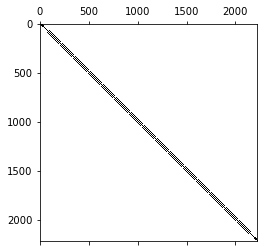

In [18]:
plt.spy(A.array())

## Time discretization

In [19]:
num_functions = 5
functions = [dolfin.Function(V) for i in range(num_functions)]
u, v, a, Ku, Cv = functions
u_vec, v_vec, a_vec, Ku_vec, Cv_vec = [func.vector() for func in functions]

In [20]:
times = dt*np.arange(num_steps+1, dtype=np.float64)
displ_tip = np.zeros_like(times)

energies = np.zeros((num_steps+1, 4), dtype=np.float64)
E_damp = 0
E_ext = 0

sig = dolfin.Function(Vsig, name="sigma")
xdmf_file = dolfin.XDMFFile("elastodynamics-results.xdmf")
xdmf_file.parameters["flush_output"] = True
xdmf_file.parameters["functions_share_mesh"] = True
xdmf_file.parameters["rewrite_function_mesh"] = False

**Question:** in the cell below:

- update `u_vec` and `v_vec` (predictor step)
- compute `f_vec`, which is the vector of (external + internal) nodal forces (the present code computes the external part only)
- update `u_vec` and `v_vec` (corrector step)

**Hint 1:** use the function `y.axpy(α, x)` to perform the operation `y ← α⋅x + y`, where `x` and `y` are two vectors and `α` is a scalar.

**Hint 2:** use the function `M.mult(x, y)` to perform the operation `y ← M⋅x`, where `x` and `y` are two vectors and `M` is a matrix.

In [21]:
u_vec.zero()
v_vec.zero()
a_vec.zero()
Ku_vec.zero()

time_solve = 0.

for n in range(num_steps):
    # Predictor step
    # u_t = u + dt * v_t +  a_t * (1 - 2*beta) * dt**2 / 2
    u_vec.axpy(dt, v_vec)
    u_vec.axpy((.5-beta)*dt**2, a_vec)
    # v_t = v + a_t * (1 - gamma) * dt 
    v_vec.axpy((1.-gamma)*dt, a_vec)

    # Update acceleration
    traction.t = (n+1)*dt
    f = dolfin.assemble(L(dolfin.TestFunction(V)))
    
    # F_t = F - C v_t - K u_t
    C.mult(v_vec, Cv_vec) 
    K.mult(u_vec, Ku_vec) 
    f.axpy(-1., Cv_vec)
    f.axpy(-1., Ku_vec)
    
    for bc in bcs:
        bc.apply(f)
    
    t1 = time.perf_counter()
    # Solve with  A a_vec = F_t
    # with A = (M + gamma * dt * C + beta * dt**2 * K)
    solver.solve(a_vec, f)
    t2 = time.perf_counter()
    time_solve += t2 - t1
    
    # Corrector step
    # u = 
    u_vec.axpy(beta*dt**2, a_vec)
    v_vec.axpy(gamma*dt, a_vec)
    
    displ_tip[n+1] = u(Lx,0)[1]
    
    E_elas = dolfin.assemble(0.5*k(u, u))
    E_kin = dolfin.assemble(0.5*m(v, v))
    E_damp += dt*dolfin.assemble(c(v, v))
    E_tot = E_elas+E_kin+E_damp
    energies[n+1, :] = np.array([E_elas, E_kin, E_damp, E_tot])
    
    local_project(stress_strain(strain_displacement(u)), Vsig, sig)

    # Save solution to XDMF format
    xdmf_file.write(u, n)
    xdmf_file.write(sig, n)

print(time_solve)

0.02969574200000835


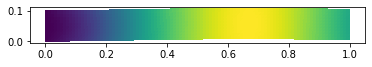

In [22]:
dolfin.plot(u, mode="displacement")

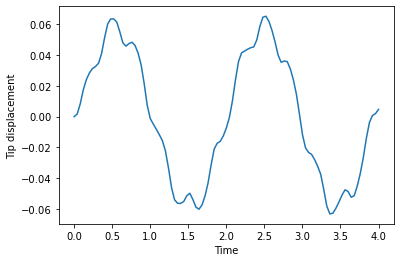

In [23]:
plt.figure()
plt.plot(times, displ_tip, '-')
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.savefig("tip_displacement.png")

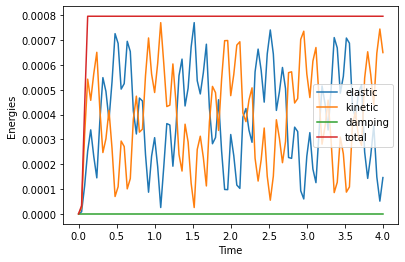

In [24]:
plt.figure()
plt.plot(times, energies)
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()